In [1]:
# Import de librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
import xgboost as xgb
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from interpret.blackbox import LimeTabular
from interpret.blackbox import ShapKernel
from xgboost import XGBRegressor

c:\Users\david\Desktop\bug-prediction-explanation\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONSTANTES
TEST_SIZE = 0.2
ENTRY_TO_EXPLAIN = 1
DATA_FILE = './datasets/dataset.xlsx'
SHEET_NAME = 'method'
# 0: sin modificaciones en los datos
# 1: oversampling
# 2: undersampling
DESBALANCEO = 2
# 0: StandardScaler
# 1: MinMaxScaler
NORMALIZACION = 1
ENTRIES_TO_EXPLAIN = [5, 10, 14]

# Preprocesado de datos

## Obtención del conjunto de datos

In [3]:
# Importado de los datos al dataframe
df_original = pd.read_excel(DATA_FILE, sheet_name=SHEET_NAME)
df = df_original
df.head()

,Project,Hash,LongName,CC,CCL,CCO,CI,CLC,CLLC,LDC,...,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules,Number of Bugs,Buggy
0,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.ClientTimeoutTest.testTim...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,1
1,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.connection.nio.ClientConn...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.connection.nio.ClientConn...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.connection.nio.ClientConn...,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
4,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.spi.impl.ClusterListenerT...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1


## Reducción de datos

### Columnas no útiles

In [4]:
# Eliminación de columnas no útiles para el estudio
df = df.drop(['Project', 'Hash', 'LongName', 'Number of Bugs'], axis=1)
df

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,HCPL,HDIF,...,Migration15 Rules,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules,Buggy
0,0,0,0,0,0,0,0,0,148093,163636,...,0,0,0,0,0,0,1,1,0,1
1,0,0,0,0,0,0,0,0,212183,248,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,299316,36,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,349426,4386,...,0,0,0,0,1,0,1,0,0,1
4,0,0,0,0,0,0,0,0,513541,536364,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108101,0,0,0,0,0,0,0,0,118039,33,...,0,0,0,0,0,0,0,0,0,0
108102,0,0,0,0,0,0,0,0,213303,308571,...,0,0,0,0,1,0,0,0,0,0
108103,0,0,0,0,0,0,0,0,247176,303947,...,0,0,0,0,1,0,0,0,0,0
108104,0,0,0,0,0,0,0,0,193219,368,...,0,0,0,0,1,0,0,0,0,0


### Columnas con único valor

In [5]:
# Eliminación de columnas con un único valor
df = df[[i for i in df if len(set(df[i])) > 1]]
df

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,HCPL,HDIF,...,Migration Rules,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules,Buggy
0,0,0,0,0,0,0,0,0,148093,163636,...,0,0,0,0,0,0,1,1,0,1
1,0,0,0,0,0,0,0,0,212183,248,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,299316,36,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,349426,4386,...,0,0,0,0,1,0,1,0,0,1
4,0,0,0,0,0,0,0,0,513541,536364,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108101,0,0,0,0,0,0,0,0,118039,33,...,0,0,0,0,0,0,0,0,0,0
108102,0,0,0,0,0,0,0,0,213303,308571,...,0,0,0,0,1,0,0,0,0,0
108103,0,0,0,0,0,0,0,0,247176,303947,...,0,0,0,0,1,0,0,0,0,0
108104,0,0,0,0,0,0,0,0,193219,368,...,0,0,0,0,1,0,0,0,0,0


### Filas duplicadas
La eliminación de filas duplicadas no se contempla debido a la conveniencia de reforzar el modelo ante las mismas situaciones encontradas 

In [6]:
# Comprobación de filas duplicadas
# print('Filas duplicadas: ', df.duplicated().sum())
# Eliminación de las filas duplicadas
# df = df.drop_duplicates()
# Comprobación de la eliminación correcta de las filas duplicadas eliminadas
print('Filas duplicadas: ', df.duplicated().sum())

Filas duplicadas:  27483


### Valores NULL
No se han encontrado valores NULL que gestionar

In [7]:
print('Valores Null: ', df.isnull().sum().sum())

Valores Null:  0


### Valores atípicos

In [8]:
def muestra_atipicos(data: pd.DataFrame):
    plt.figure(figsize=(15, 3))
    data.boxplot()
    plt.xticks(rotation=90)
    plt.show()

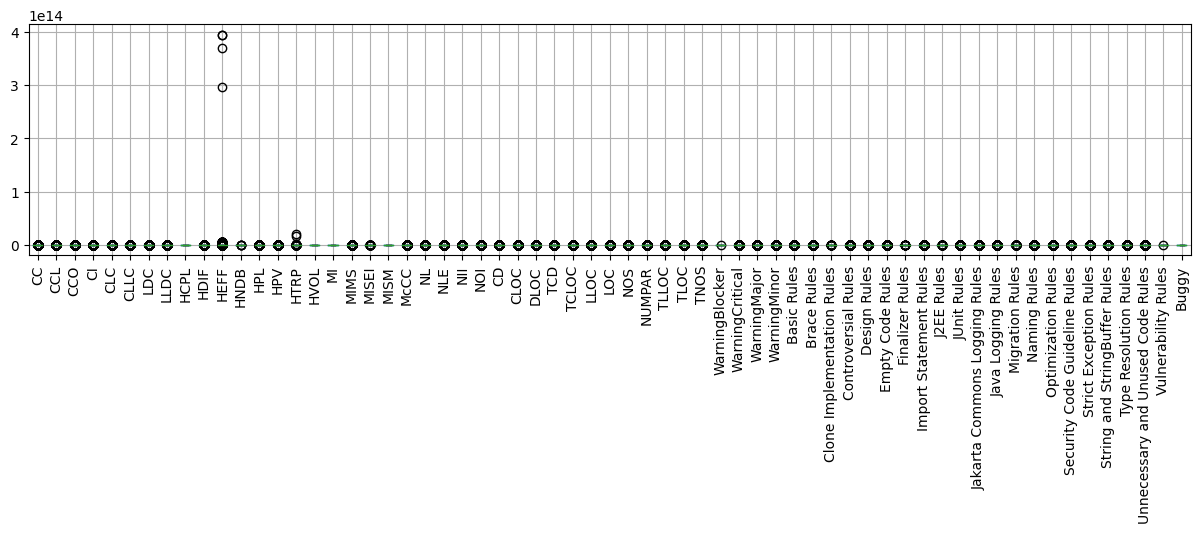

In [9]:
# Muestra de los valores atípicos para cada una de las features
muestra_atipicos(df)

No se realiza el proceso de eliminado de los valores atípicos porque se ha comprobado que reduce la calidad del modelo

In [10]:
# def cap_data(df):
#     for col in df.columns:
#         print("capping the ",col)
#         if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
#             percentiles = df[col].quantile([0.01,0.99]).values
#             df[col][df[col] <= percentiles[0]] = percentiles[0]
#             df[col][df[col] >= percentiles[1]] = percentiles[1]
#         else:
#             df[col]=df[col]
#     return df

# final_df=cap_data(df)
# df = final_df

In [11]:
# # Muestra de los valores atípicos una vez realizada la limpieza para cada una de las features
# muestra_atipicos(df)

## Separación de features y salida
Separación de los valores en los conjuntos de datos de entrada y salida de los modelos de predicción
x = entrada
y = salida

In [12]:
x = df.drop('Buggy', axis=1)  # valores de entrada
y = df['Buggy']  # valores de salida

In [13]:
x

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,HCPL,HDIF,...,Java Logging Rules,Migration Rules,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules
0,0,0,0,0,0,0,0,0,148093,163636,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,212183,248,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,299316,36,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,349426,4386,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,513541,536364,...,2,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108101,0,0,0,0,0,0,0,0,118039,33,...,0,0,0,0,0,0,0,0,0,0
108102,0,0,0,0,0,0,0,0,213303,308571,...,0,0,0,0,0,1,0,0,0,0
108103,0,0,0,0,0,0,0,0,247176,303947,...,0,0,0,0,0,1,0,0,0,0
108104,0,0,0,0,0,0,0,0,193219,368,...,0,0,0,0,0,1,0,0,0,0


In [14]:
y

0         1
1         1
2         1
3         1
4         1
         ..
108101    0
108102    0
108103    0
108104    0
108105    1
Name: Buggy, Length: 108106, dtype: int64

# Conjuntos de entrenamiento y test
División del dataframe en los conjuntos de test y entrenamiento

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=42)

### Normalización
Esta normalización ha de hacerse una vez construidos los conjuntos de test y entrenamiento, para que los datos de test no afecten a la normalización de los datos de entrenamiento. 

Ha de usarse la misma escala para toodos los datos por lo que esta se extrae de los datos de entrenamiento y se aplica a los de testeo (Similar a lo que pasaría si tuviéramos que predecir un nuevo dato no incluido en el dataset, con el escalador con el que se ha entrenado el modelo, se efectua la normalización sobre el nuevo dato).

La normalización de la salida no es necesario pues solo se contemplan dos valores, 1 y 0, por lo tanto, su normalización consistiría y asignar los extremos del rango seleccionado, el inferior para los de valor 0 y el superior para los de valor 1. 

In [16]:
# Normalización de los conjuntos
# Selección de algoritmo de normalización
if (NORMALIZACION == 0):  # StandardScaler
    scaler = StandardScaler()
elif (NORMALIZACION == 1):  # MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 100000000))

X_train_normalized = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

y_train_normalized = y_train

X_test_normalized = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

y_test_normalized = y_test

In [17]:
X_train_normalized.describe()

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,HCPL,HDIF,...,Java Logging Rules,Migration Rules,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules
count,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,...,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04,8.648400e+04
mean,4.830162e+06,1.423410e+05,1.730034e+04,8.845731e+04,4.086117e+06,4.081778e+06,1.252987e+05,1.292028e+05,3.374948e+07,1.681710e+07,...,9.861085e+04,1.638068e+04,6.043025e+05,8.564205e+04,1.348997e+05,8.772886e+05,1.420520e+05,1.600643e+06,7.864190e+04,1.156283e+03
std,1.722612e+07,2.502735e+06,5.694006e+05,2.393083e+06,1.542717e+07,1.545468e+07,2.377674e+06,2.504244e+06,2.556530e+07,2.439951e+07,...,9.561772e+05,7.830781e+05,3.013655e+06,1.130466e+06,2.279909e+06,3.313214e+06,1.252835e+06,4.092299e+06,1.870799e+06,3.400417e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.386213e+07,4.402038e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.653177e+07,4.513090e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.874869e+07,2.671069e+07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,...,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08,1.000000e+08


## Desbalanceo de datos

In [18]:
# Comprobación de la cantidad de datos para cada una de las salidas
print(Counter(y_train_normalized))

Counter({0: 59837, 1: 26647})


### Random Oversampling
De manera aleatoria duplica ejemplos en la clase minoritaria.

Al igual que la normalización, esta técnica de muestreo es necesario aplicarla sobre os conjuntos divididos de testeo y entrenamiento ya que si se realiza antes, los datos de entrenamiento estarán contaminados por los de test, existiendo la posibilidad de que al replicar las entradas se esojan estas entradas tanto para el conjunto de testeo como para el de entrenamiento.

In [19]:
# Usando "minority" como "sampling_strategy" se consigue que si por ejemplo la clase mayoritaria tiene 1000 entradas y la minoritaria 100, la clase minoritaria replicará aleatoriamente las entradas hasta llegar a las 1000 de la clase mayoritaria
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_normalized_oversampled, y_train_normalized_oversampled = oversample.fit_resample(
    X_train_normalized, y_train_normalized)
print(Counter(y_train_normalized_oversampled))

Counter({0: 59837, 1: 59837})


### Undersampling

In [20]:
# Estableciendo la "sampling_strategy" a "majority" se undersamplea la clase mayoritaria, de tal modo que si la clase minoritaria tiene 100 ejemplos y la mayoritaria tiene 200, despues de realizar la técnica, ambas clases tendrán 100 ejemplos (se eliminarán de la clase mayoritaria aleatoriamente)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_train_normalized_undersampled, y_train_normalized_undersampled = undersample.fit_resample(
    X_train_normalized, y_train_normalized)
print(Counter(y_train_normalized_undersampled))

Counter({0: 26647, 1: 26647})


# Modelos de clasificación

In [21]:
# Selección del
# Original sin corrección de desbalanceo
if (DESBALANCEO == 0):
    X_train = X_train_normalized
    y_train = y_train_normalized

# Undersampling
elif (DESBALANCEO == 1):
    X_train = X_train_normalized_undersampled
    y_train = y_train_normalized_undersampled

# Oversampling
elif (DESBALANCEO == 2):
    X_train = X_train_normalized_oversampled
    y_train = y_train_normalized_oversampled

X_test = X_test_normalized
y_test = y_test_normalized

## Ajuste de hiperparámetros
Antes de la construcción del modelo de random forest comprobamos los mejores hiperparámetros para el modelo.

Grid Search es una técnica de validación cruzada que ejecuta la combinación entre los parámetros introducidos como entrada para seleccionar la mejor combinación de estos.

HIPERPARÁMETROS: 
  - n_estimators: representa el número de estimadores (árboles de decisión en este caso) que se deben utilizar en el modelo
  - max_depth: indica la profundidad máxima de los árboles del modelo 
  - min_samples_split: determina el número de muestras requeridas para diidir un nodo en un árbol. Influye en la resistencia frente al ruido de los datos. 
  - max_features: controla el número máximo de características que se consideran al buscar la mejor deisión en un nodo del árbol 
  
PARÁMETROS: 
  - cv: indica la estrategia de validación cruzada seguida 
  - neg_root_mean_squared_error: error cuadrático medio expresado en su forma negativa 
  - r2: indica cuanto se explica la variabilidad de los datos a través del modelo de regresión. Sus valores oscilan entre 0 y 1, siendo mejores cuanto más próximos a 1 se encuentren

## Random Forest

In [28]:
rf = RandomForestClassifier(random_state=42)

search_space = {
    "max_depth": [75, 100, 125],
    "max_features": [15, 30, 70],
    "min_samples_leaf": [1],
    "min_samples_split": [3, 5, 10],
    "n_estimators": [100, 150, 300]
}
# search_space = {
#     "max_depth": [75, 100, 150],
#     "max_features": [1, 4, 7],
#     "min_samples_leaf": [1, 3],
#     "min_samples_split": [1, 2],
#     "n_estimators": [500, 600, 700]
# }

GS = GridSearchCV(estimator=rf,
                  param_grid=search_space,
                  scoring="roc_auc",
                  refit="roc_auc",
                  cv=5,
                  verbose=4,
                  n_jobs=-1)

# GS.fit(X_train, y_train)

# print(GS.best_params_)

# Resultados para el mejor F1-score
MAX_DEPTH_RF = 100 # > 200 > 300 > 25, 75
MAX_FEATURES_RF = 4 # > 3 > 5 > 6 > 1 > 20
MIN_SAMPLES_LEAF_RF = 1 # > 3
MIN_SAMPLES_SPLIT_RF = 1 # > 2
N_ESTIMATORS_RF = 600 # > 700 > 500 > 1000

# Resultados para la mejor predicción de la clase Buggy
# MAX_DEPTH_RF = 15
# MAX_FEATURES_RF = 10
# MIN_SAMPLES_LEAF_RF = 3
# MIN_SAMPLES_SPLIT_RF = 15
# N_ESTIMATORS_RF = 50





In [29]:
# Creación del modelo de random forest con los hiperparámetros seleccionados del paso anterior

# Modelo rápido para pruebas. No tiene buenos resultados pero si ofrece rapidez en el entrenamiento para realizar pruebas que no necesiten resultados óptimos
# rf = RandomForestClassifier(max_depth = 18, max_features = 10, min_samples_leaf = 10, min_samples_split = 10, n_estimators = 50, n_jobs = -1)

# Modelo completo
rf = RandomForestClassifier(max_depth=MAX_DEPTH_RF, max_features=MAX_FEATURES_RF, min_samples_split=MIN_SAMPLES_SPLIT_RF,
                            n_estimators=N_ESTIMATORS_RF, min_samples_leaf=MIN_SAMPLES_LEAF_RF, n_jobs=-1)

## XGBoost

In [24]:
xgb_model = XGBRegressor(random_state=42)

search_space = {
    "n_estimators": [200, 500, 1000],
    "max_depth": [50, 100, 200],
    'gamma': [0.2, 0.5, 0.75],
    'learning_rate': [0.01, 0.1, 0.3]
}

GS = GridSearchCV(estimator=xgb_model,
                  param_grid=search_space,
                  scoring="f1_weighted",
                  refit="f1_weighted",
                  cv=5,
                  verbose=4,
                  n_jobs=-1)

# GS.fit(X_train, y_train)

# print(GS.best_params_)

In [30]:
N_ESTIMATORS_XGB = 200
MAX_DEPTH_XGB = 50
GAMMA_XGB = 0.2
LEARNING_RATE_XGB = 0.01

# Definición del modelo XGBoost
# xgb_model = xgb.XGBClassifier(gamma = 0.01, learning_rate = 0.01, max_depth = 1000, n_estimators = 1000, n_jobs = -1)
xgb_model = xgb.XGBClassifier(gamma=GAMMA_XGB, learning_rate=LEARNING_RATE_XGB,
                              max_depth=MAX_DEPTH_XGB, n_estimators=N_ESTIMATORS_XGB, n_jobs=-1)

## Evaluación del modelo

http://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example/

### Métricas de evaluación

**Confusion Matrix**

Una matriz de confusión es una forma de expresar cuántas predicciones de un clasificador fueron correctas y, cuando son incorrectas, dónde el clasificador se confundió (de ahí el nombre). En las matrices de confusión a continuación, las filas representan las etiquetas verdaderas y las columnas representan las etiquetas predichas. Los valores en la diagonal representan el número (o porcentaje, en una matriz de confusión normalizada) de veces en que la etiqueta predicha coincide con la etiqueta verdadera. Los valores en las otras celdas representan instancias donde el clasificador etiquetó incorrectamente una observación; la columna nos dice qué predijo el clasificador y la fila nos dice cuál era la etiqueta correcta. Esta es una forma conveniente de identificar áreas donde el modelo puede necesitar un poco de entrenamiento adicional.

**Precision**

Precision es el número de miembros de una clase que el modelo ha identificado correctamente dividido entre todas las veces que el modelo ha predicho esa clase.

**Recall**

La sensibilidad o recall es el número de miembros de una clase que el clasificador identificó correctamente dividido por el número total de miembros en esa clase.

**F1 score**

El F1 score es un poco menos intuitivo porque combina precisión y recall en una sola métrica. Si tanto la precisión como el recall son altos, F1 también será alto. Si ambos son bajos, F1 será bajo. Si uno es alto y el otro bajo, F1 será bajo. F1 es una forma rápida de saber si el clasificador es realmente bueno para identificar miembros de una clase, o si está encontrando atajos (por ejemplo, simplemente identificando todo como miembro de una clase grande).

The weighted-averaged F1 score is calculated by taking the mean of all per-class F1 scores while considering each class’s support. Support refers to the number of actual occurrences of the class in the dataset. For example, the support value of 1 in Boat means that there is only one observation with an actual label of Boat. The ‘weight’ essentially refers to the proportion of each class’s support relative to the sum of all support values.

In [31]:
def evaluacion_modelo(model, x_test, y_test, prediccion):
    # Observar el resumen de la clasificación para el conjunto de test y sus predicciones
    print(classification_report(y_test, prediccion))

    conf_matrix = confusion_matrix(y_test, prediccion)
    conf_matrix = conf_matrix.astype(
        'float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Confusion matrix usando un heat map
    sns.set(font_scale=1)
    sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Greens)

    # Etiquetas
    class_names = ['Not Buggy', 'Buggy']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=30)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted value')
    plt.ylabel('Actual value')
    plt.title('Confusion matrix')
    plt.show()

    # Calculo de la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # plot de la curva ROC
    plt.plot(fpr, tpr, label="Curva ROC (AUC = {:.2f})".format(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle="--", label="Predicción aleatoria")
    plt.xlabel("Tasa Falso Positivo")
    plt.ylabel("Tasa Verdadero Positivo")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()

### Random Forest

              precision    recall  f1-score   support

           0       0.78      0.88      0.82     14945
           1       0.61      0.44      0.51      6677

    accuracy                           0.74     21622
   macro avg       0.70      0.66      0.67     21622
weighted avg       0.73      0.74      0.73     21622



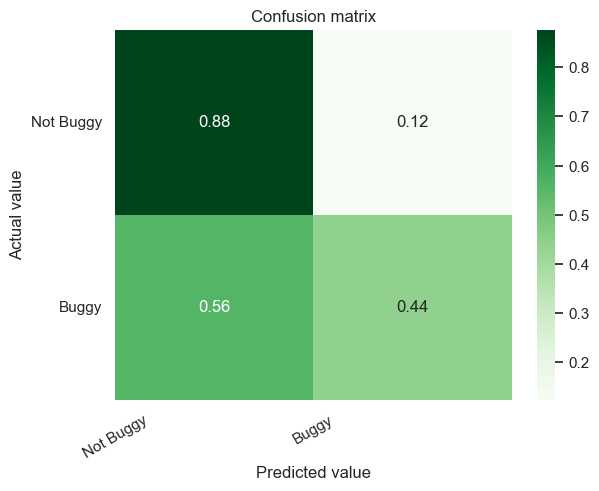

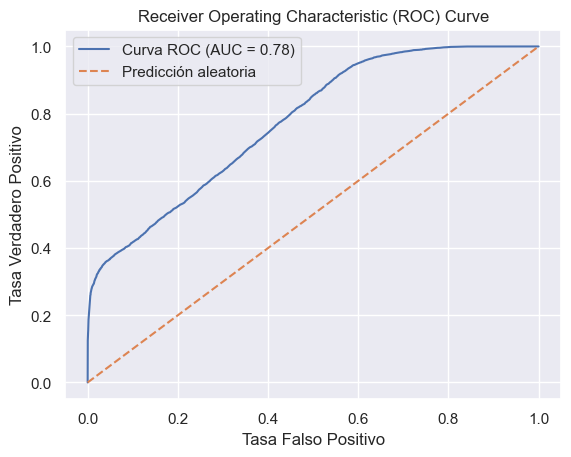

In [32]:
# Entrenamiento del modelo
rf.fit(X_train, y_train)

# Comprobamos la precisión en las predicciones del modelo
y_pred_rf = rf.predict(X_test)
evaluacion_modelo(rf, X_test, y_test, y_pred_rf)

### XGBoost

              precision    recall  f1-score   support

           0       0.79      0.82      0.80     14945
           1       0.56      0.50      0.53      6677

    accuracy                           0.72     21622
   macro avg       0.67      0.66      0.67     21622
weighted avg       0.72      0.72      0.72     21622



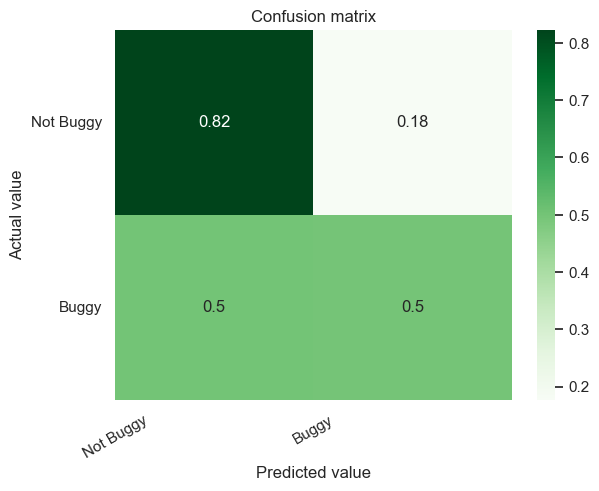

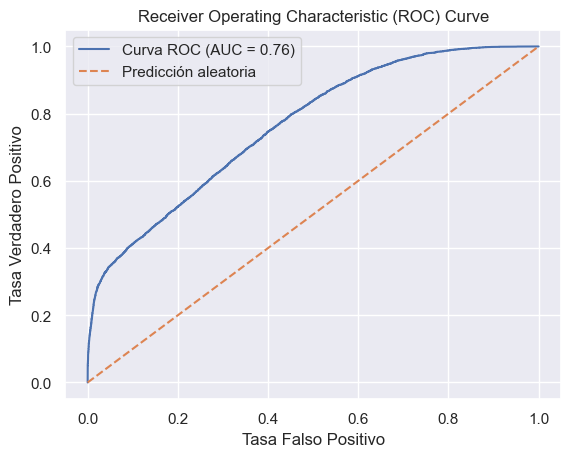

In [33]:
# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Comprobamos la precisión en las predicciones del modelo
y_pred_xgb = xgb_model.predict(X_test)
evaluacion_modelo(xgb_model, X_test, y_test, y_pred_xgb)

# Reducción de dimensionalidad
https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

<Axes: >

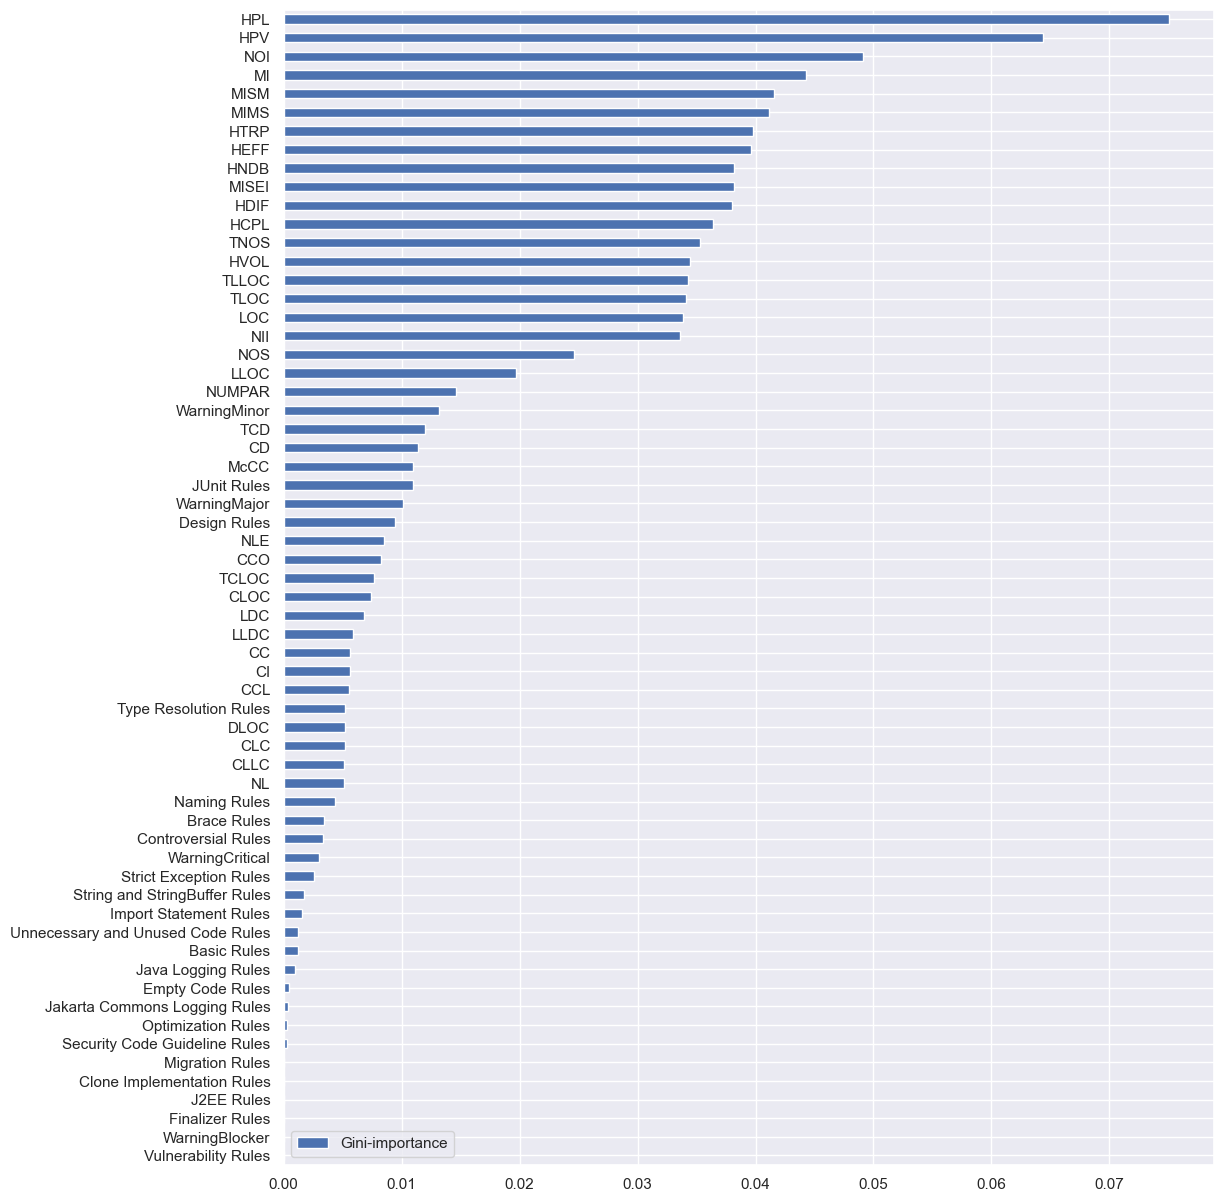

In [64]:
feats = {}  # Diccionario para contener el par feature_name: feature_importance
for feature, importance in zip(x.columns, rf.feature_importances_):
    feats[feature] = importance  # add the name/value pair

importances = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(
    by='Gini-importance').plot(kind='barh', figsize=(12, 15))

Text(0.5, 1.0, 'Importancias acumuladas')

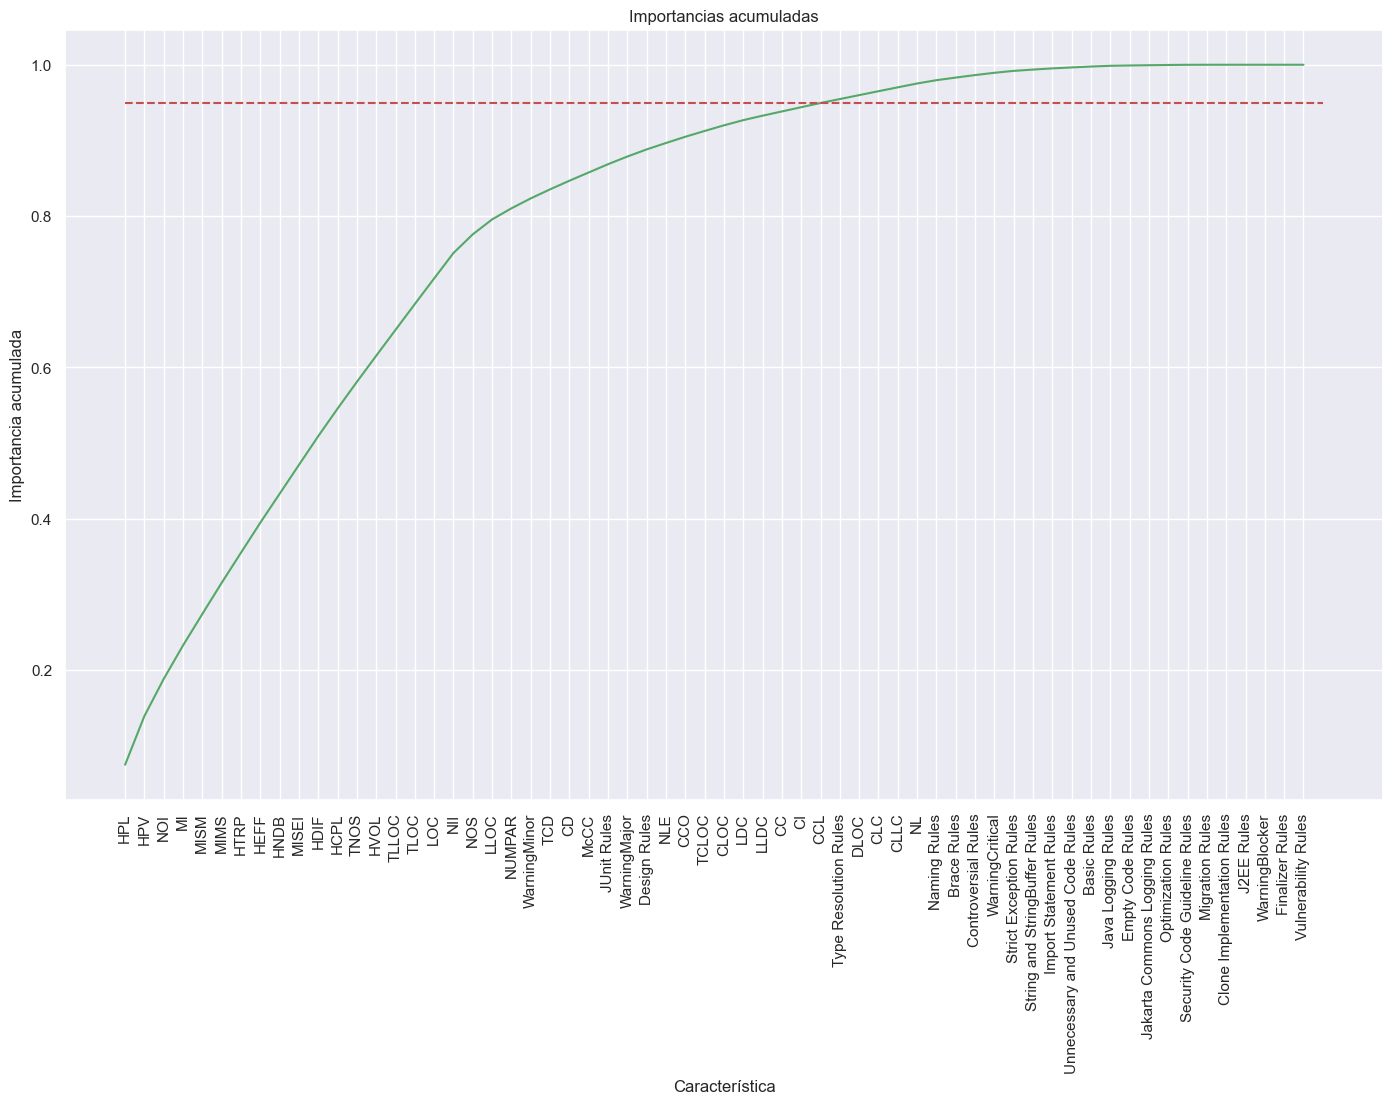

In [65]:
# Obtener las importancias de manera numérica
importances = list(rf.feature_importances_)
# Lista de tuplas con la variable y la importancia asociada
feature_importances = [(feature, importance)
                       for feature, importance in zip(x.columns, importances)]
# Ordenar las características por orden de imporatancia, con la más importante primero
feature_importances = sorted(
    feature_importances, key=lambda x: x[1], reverse=True)
# Imprimir la característica y la importancia asociada
# [print('Característica: {:20} Importancia: {}'.format(*pair)) for pair in feature_importances]

x_values = list(range(len(importances)))
# Lista de features ordenadas por importancia
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Importancia acumulada
cumulative_importances = np.cumsum(sorted_importances)
# Línea gráfica
plt.figure(figsize=(17, 10))
plt.plot(x_values, cumulative_importances, 'g-')
# Línea roja en el 95% de importancia
plt.hlines(y=0.95, xmin=0, xmax=len(sorted_importances),
           color='r', linestyles='dashed')
# Formato para el eje X
plt.xticks(x_values, sorted_features, rotation='vertical')
# Etiquetas y título
plt.xlabel('Característica')
plt.ylabel('Importancia acumulada')
plt.title('Importancias acumuladas')

In [66]:
# Se busca la cantidad de características que tienen una importancia acumulada del 95%
# Se añade una por el indexado en la posición 0
n_important = np.where(cumulative_importances > 0.95)[0][0] + 1
print('Número de características para el 95% de importancia:', n_important)

# Lista de nombres de las variables mas importantes
important_feature_names = [feature[0]
                           for feature in feature_importances[0:n_important]]
# Lista de indices de las variables mas importantes
important_indices = [list(x.columns).index(feature)
                     for feature in important_feature_names]
print(tuple(zip(important_feature_names, important_indices)))

# Creación de los conjuntos de entrenamiento y test reducido solo con las características más importantes
X_train_reduced = X_train.iloc[:, important_indices]
X_test_reduced = X_test.iloc[:, important_indices]
# Comprobación de los conjuntos generados
print('Conjunto de entrenamiento reducido:', X_train_reduced.shape)
print('Conjunto de testeo reducido:', X_test_reduced.shape)

Número de características para el 95% de importancia: 38
(('HPL', 12), ('HPV', 13), ('NOI', 24), ('MI', 16), ('MISM', 19), ('MIMS', 17), ('HTRP', 14), ('HEFF', 10), ('HNDB', 11), ('MISEI', 18), ('HDIF', 9), ('HCPL', 8), ('TNOS', 36), ('HVOL', 15), ('TLLOC', 34), ('TLOC', 35), ('LOC', 31), ('NII', 23), ('NOS', 32), ('LLOC', 30), ('NUMPAR', 33), ('WarningMinor', 40), ('TCD', 28), ('CD', 25), ('McCC', 20), ('JUnit Rules', 50), ('WarningMajor', 39), ('Design Rules', 45), ('NLE', 22), ('CCO', 2), ('TCLOC', 29), ('CLOC', 26), ('LDC', 6), ('LLDC', 7), ('CC', 0), ('CI', 3), ('CCL', 1), ('Type Resolution Rules', 59))
Conjunto de entrenamiento reducido: (119674, 38)
Conjunto de testeo reducido: (21622, 38)


## Modelo reducido

### Reajuste de hiperparámetros

In [33]:
rf_reduced = RandomForestClassifier(random_state=42)

search_space = {
    "max_depth": [10, 20, 50],
    "max_features": [5, 10],
    "min_samples_leaf": [10, 50, 100],
    "min_samples_split": [10, 50, 100],
    "n_estimators": [50, 100, 200]
}

GS_reduced = GridSearchCV(estimator=rf,
                          param_grid=search_space,
                          scoring="f1_weighted",
                          refit="f1_weighted",
                          cv=5,
                          verbose=4,
                          n_jobs=-1)

# GS_reduced.fit(X_train_reduced, y_train)

# print(GS_reduced.best_params_)

# Resultados para el mejor F1-score
# MAX_DEPTH = 100 > 30, 50, 75
# MAX_FEATURES = 5 > 10, 15
# MIN_SAMPLES_LEAF = 1 > 2
# MIN_SAMPLES_SPLIT = 1 > 2, 3
# N_ESTIMATORS = 1000 > 200, 500

# Resultados para la mejor predicción de la clase Buggy
# MAX_DEPTH = 15
# MAX_FEATURES = 5
# MIN_SAMPLES_LEAF = 3
# MIN_SAMPLES_SPLIT = 15
# N_ESTIMATORS = 50

### Creación y evaluación del modelo

              precision    recall  f1-score   support

           0       0.83      0.58      0.68     14945
           1       0.44      0.74      0.55      6677

    accuracy                           0.63     21622
   macro avg       0.64      0.66      0.62     21622
weighted avg       0.71      0.63      0.64     21622



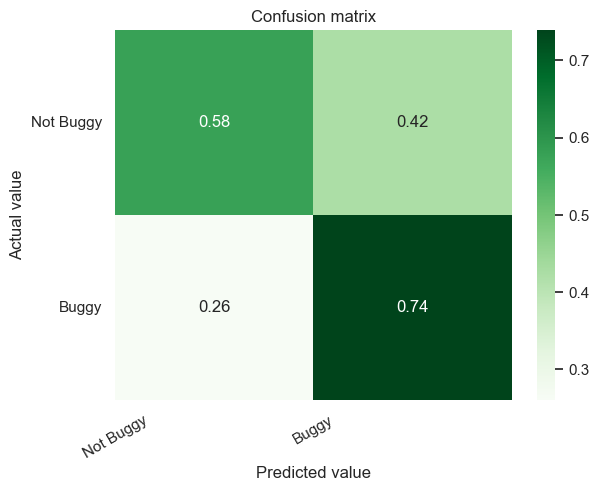

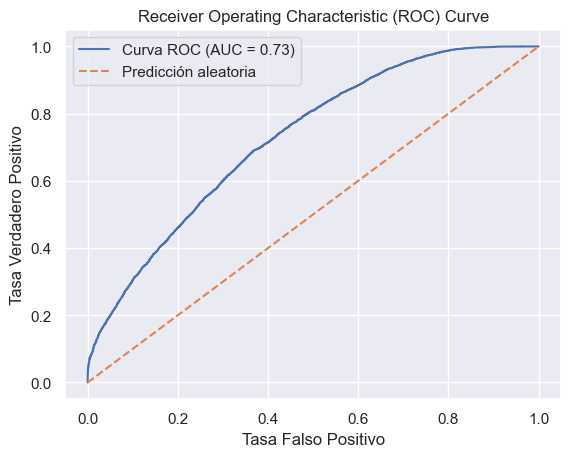

In [67]:
MAX_DEPTH = 15
MAX_FEATURES = 5
MIN_SAMPLES_LEAF = 3
MIN_SAMPLES_SPLIT = 15
N_ESTIMATORS = 50

# Modelo reducido
# rf_reduced = RandomForestClassifier(max_depth = 15, max_features = 5, min_samples_leaf = 3, min_samples_split = 15, n_estimators = 50, n_jobs = -1)
rf_reduced = RandomForestClassifier(max_depth=MAX_DEPTH, max_features=MAX_FEATURES, min_samples_leaf=MIN_SAMPLES_LEAF, min_samples_split=MIN_SAMPLES_SPLIT, n_estimators=N_ESTIMATORS, n_jobs=-1)

# Entrenamiento y evaluación del modelo
rf_reduced.fit(X_train_reduced, y_train)
y_pred = rf_reduced.predict(X_test_reduced)
evaluacion_modelo(rf_reduced, X_test_reduced, y_test, y_pred)

# Selección de instancia

In [82]:
entry_to_explain = ENTRIES_TO_EXPLAIN[2]

# Shap

In [80]:
shap_explainer = shap.TreeExplainer(rf_reduced)
shap.initjs()

## Explicaciones locales

In [89]:
shap_values = shap_explainer.shap_values(np.array(X_test_reduced.iloc[entry_to_explain]))

# Plots para SHAP
print(f'PROBABILIDADES:\n\tNO BUGGY: {rf_reduced.predict_proba(X_test_reduced)[entry_to_explain, 0]}\n\tBUGGY: {rf_reduced.predict_proba(X_test_reduced)[entry_to_explain, 1]}')

shap.force_plot(shap_explainer.expected_value[1], shap_values[1], X_test_reduced.iloc[entry_to_explain])

PROBABILIDADES:
	NO BUGGY: 0.4282529895291692
	BUGGY: 0.5717470104708307


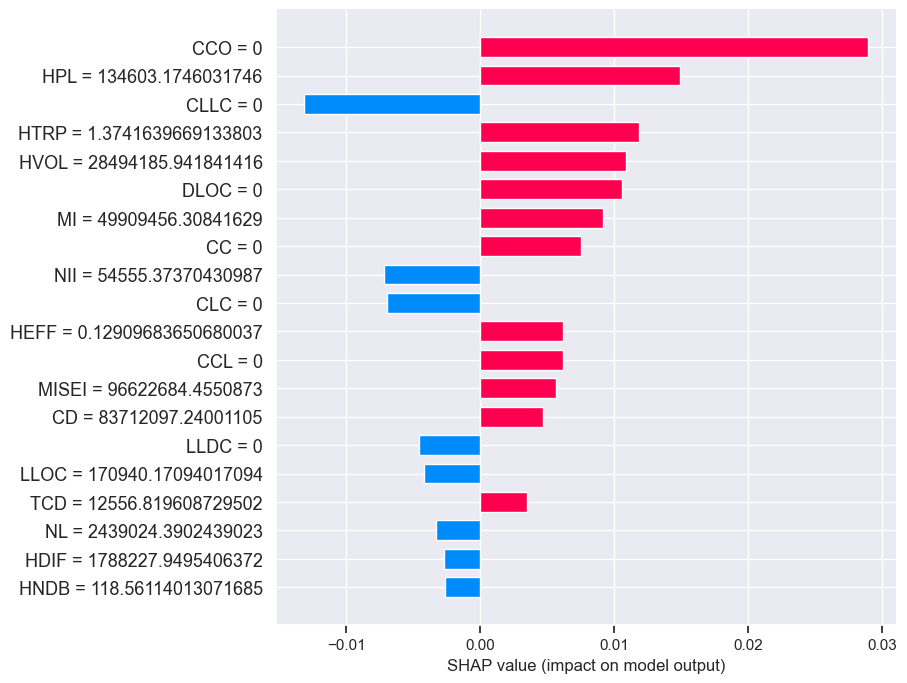

In [84]:
plt.figure(figsize=(8, 8))
shap.bar_plot(
    shap_values[1], features=X_test.iloc[entry_to_explain], max_display=20)

In [85]:
shap.initjs()
explainer_rfc = shap.Explainer(rf_reduced)
shap_values_rfc = explainer_rfc(
    X_test_reduced[entry_to_explain:entry_to_explain+1])

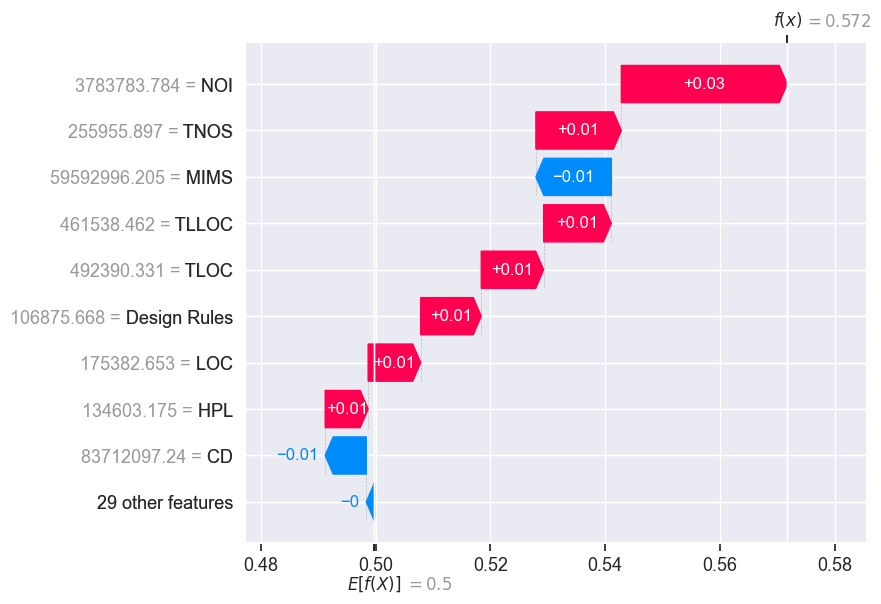

In [86]:
shap.plots.waterfall(shap_values_rfc[0, :, 1])

In [42]:
print(
    f'PROBABILIDADES:\n\tNO BUGGY: {rf_reduced.predict_proba(X_test_reduced)[entry_to_explain, 0]}\n\tBUGGY: {rf_reduced.predict_proba(X_test_reduced)[entry_to_explain, 1]}')

shap.plots.force(shap_values_rfc[0, :, 1])

PROBABILIDADES:
	NO BUGGY: 0.108
	BUGGY: 0.892


## Funciones shap

In [43]:
def shap_force_plot(data: pd.DataFrame, exp: shap.TreeExplainer, x: int):
    for i in range(x):
        sv = exp.shap_values(np.array(data.iloc[i]))
        shap.force_plot(
            exp.expected_value[1], sv[1], data.iloc[i], matplotlib=True, show=False)
        plt.savefig(f"./img/shap/{i}_force.png", dpi=200, bbox_inches='tight')
        plt.clf()


def shap_bar_plot(data: pd.DataFrame, exp: shap.TreeExplainer, x: int):
    plt.figure(figsize=(8, 8))
    for i in range(x):
        sv = exp.shap_values(np.array(data.iloc[i]))
        shap.bar_plot(sv[1], features=data.iloc[i], max_display=10, show=False)
        plt.savefig(f"./img/shap/{i}_bar.png", bbox_inches='tight')
        plt.clf()

# shap_force_plot(data=X_test_reduced, exp=shap_explainer, x=100)
# shap_bar_plot(data=X_test_reduced, exp=shap_explainer, x=100)

# Lime

In [90]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_reduced.values, feature_names=X_train_reduced.columns, class_names=[
                                                        'Not Buggy', 'Buggy'], verbose=True, mode='classification')

In [91]:
# Cada vez que se ejecuta el explicador, lime genera datos cercanos perturbando las features de la instancia, esto puede hacer que en cada iteración el resultado del peso de las variabes sobre la predicción varíe. Ver https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_tabular.LimeTabularExplainer.explain_instance
exp = lime_explainer.explain_instance(
    X_test_reduced.values[entry_to_explain], rf_reduced.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.4369534413957229
Prediction_local [0.46202054]
Right: 0.5717470104708308


## Funciones Lime

In [46]:
def lime_explain(data: pd.DataFrame, explainer: lime.lime_tabular.LimeTabularExplainer, model: RandomForestClassifier, x: int):
    for i in range(x):
        exp = explainer.explain_instance(
            data.iloc[i], model.predict_proba, num_features=10, top_labels=1)
        exp.save_to_file(f"./img/lime/{i}.html")

# lime_explain(data=X_test_reduced, explainer=lime_explainer, model=rf_reduced, x=100)

# IntepretML (SHAP y LIME a la vez)
https://github.com/interpretml/interpret/tree/develop

https://github.com/interpretml/interpret/blob/develop/examples/python/Explaining_Blackbox_Classifiers.ipynb

In [47]:
background_val = pd.DataFrame(np.median(X_train_reduced, axis=0).reshape(
    1, -1), columns=X_train_reduced.columns)
sp = ShapKernel(rf_reduced, background_val)
shap_local = sp.explain_local(X_test_reduced[:5], y_test[:5], name='SHAP')

# Blackbox explainers need a predict function, and optionally a dataset
lim = LimeTabular(rf_reduced, X_train_reduced, random_state=1)

# Pick the instances to explain, optionally pass in labels if you have them
lime_local = lim.explain_local(X_test_reduced[:100], y_test[:100], name='LIME')

# show([lime_local, shap_local])

100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


# Tree schemas
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [48]:
# Ejectura esta parte si está instalado graphviz en el equipo
# from sklearn.tree import export_graphviz
# import graphviz
# for i in [5, 23, 30, 47, 70, 95]:
#     tree = rf.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=X_train.columns,
#                                filled=True,
#                                max_depth=4,
#                                impurity=False,
#                                proportion=True)
#     graph = graphviz.Source(dot_data)
#     graph.render(filename=f'g1.dot')
#     display(graph)